In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader,PyMuPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_core.runnables import RunnableParallel,RunnablePassthrough,RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain.retrievers import EnsembleRetriever,ContextualCompressionRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_cohere import CohereRerank
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
load_dotenv()

True

### Document Loading

In [2]:
def doc_load(path):
    return DirectoryLoader(path,glob="*.pdf",loader_cls=PyMuPDFLoader).load()

path_to_dentist = "data/Dentist"
path_to_biology = "data/Dermatology"
path_to_psychiartrist = "data/psychiatrist"


dentist_document = doc_load(path_to_dentist)
dermatology_document = doc_load(path_to_biology)
psychiatrist_document = doc_load(path_to_psychiartrist)


print("len of dermatology ",len(dermatology_document))
print("len of dentist ",len(dentist_document))
print("len of psychiatrist ",len(psychiatrist_document))

len of dermatology  959
len of dentist  1449
len of psychiatrist  1825


### Text Chunking

In [3]:
def text_splitter(doc):
    return RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=400).split_documents(doc)

dermatology_chunks = text_splitter(dermatology_document)
dentist_chunks = text_splitter(dentist_document)
psychiatrist_chunks = text_splitter(psychiatrist_document)

print("len of dentist chunnks:",len(dentist_chunks))
print("len of dermatology chunnks:",len(dermatology_chunks))
print("len of psychiatrist chunnks:",len(psychiatrist_chunks))

len of dentist chunnks: 4484
len of dermatology chunnks: 2030
len of psychiatrist chunnks: 4088


### Creating Vector Store

In [ ]:
from langchain.vectorstores import FAISS
import os
from tqdm import tqdm

embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",batch_size=20)

batch_size=35
def create_vector_store(chunks,path):
    vectore_store =None
    for i in tqdm(range(0,len(chunks),batch_size)):
        batch = chunks[i:i+batch_size]
        if vectore_store is None:
            vectore_store = FAISS.from_documents(embedding=embedding_model,documents=batch)
        else:
            new_store = FAISS.from_documents(embedding=embedding_model,documents=batch)
            vectore_store.merge_from(new_store)
    vectore_store.save_local(folder_path=path)
    return vectore_store


os.makedirs("FAISS/dermatology", exist_ok=True)
os.makedirs("FAISS/dentis", exist_ok=True)
os.makedirs("FAISS/psychiatrist", exist_ok=True)


dermatology_vector_store_path = "FAISS/dermatology/"
dentis_vector_store_path =  "FAISS/dentis/"
psychiatrist_store_path = "FAISS/psychiatrist"


dermatology_vector_store = create_vector_store(dermatology_chunks,dermatology_vector_store_path) 
dentis_vector_store = create_vector_store(dentist_chunks,dentis_vector_store_path)
psychiatrist_store = create_vector_store(psychiatrist_chunks,psychiatrist_store_path)


print("Vector store created successfult")


  0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 117/117 [03:14<00:00,  1.66s/it]

Vector store created successfult


## Loading Vector Stores

In [6]:
from langchain.vectorstores import FAISS
dermatology_vector_store_path = "FAISS/dermatology/"
dentis_vector_store_path =  "FAISS/dentis/"
psychiatrist_store_path = "FAISS/psychiatrist"

embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",batch_size=20)

dermatology_vector_store = FAISS.load_local(folder_path=dermatology_vector_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)
dentis_vector_store = FAISS.load_local(folder_path=dentis_vector_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)
psychiatrist_vector_store = FAISS.load_local(folder_path=psychiatrist_store_path,embeddings=embedding_model,allow_dangerous_deserialization=True)

### Retriever(Dense)

In [7]:
dermatology_retriever = dermatology_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":4})
dentist_retriever = dentis_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":4})
psychiatrist_retriever = psychiatrist_vector_store.as_retriever(search_type="mmr",search_kwargs={"k":4})


psychiatrist_retriever.invoke("mental health issue in world")

[Document(id='2df27fb6-da31-4808-9345-a5ae48c45a7f', metadata={'producer': 'Acrobat Distiller 10.0.0 (Windows)', 'creator': 'Microsoft® Office Publisher 2007', 'creationdate': '2014-01-14T15:39:55-05:00', 'source': 'data\\psychiatrist\\MHGuidebook-EBookDownload.pdf', 'file_path': 'data\\psychiatrist\\MHGuidebook-EBookDownload.pdf', 'total_pages': 261, 'format': 'PDF 1.3', 'title': 'merged.pdf', 'author': 'pam smith', 'subject': '', 'keywords': '', 'moddate': '2014-01-14T16:06:51-05:00', 'trapped': '', 'modDate': "D:20140114160651-05'00'", 'creationDate': "D:20140114153955-05'00'", 'page': 229}, page_content='References \n229 \nPART I: Mental Health Worldwide \nGhodse H. International Perspectives on Mental Health. London: \nRoyal College of Psychiatrists; 2011. <http://public.eblib.com/\nEBLPublic/PublicView.do?ptiID=730210>. Accessed August 8, \n2013.  \n \nKessler RC, Ustun TB. The WHO World Mental Health Surveys: \nGlobal Perspectives on the Epidemiology of Mental Disorders. \nNew Y

## Retriever(Sparse)

In [8]:
bm25_retriever_dentist = BM25Retriever.from_documents(dentist_chunks)
bm25_retriever_dentist.k=4

bm25_retriever_dermatology = BM25Retriever.from_documents(dermatology_chunks)
bm25_retriever_dermatology.k=4

bm25_retriever_psychiatrist = BM25Retriever.from_documents(psychiatrist_chunks)
bm25_retriever_psychiatrist.k=4

### Dense Retriever

In [9]:
hybrid_retrieval_dermatology = EnsembleRetriever(
    retrievers=[dermatology_retriever,bm25_retriever_dermatology],
    weights=[0.4,0.6]
)

hybrid_retrieval_dentist = EnsembleRetriever(
    retrievers=[dentist_retriever,bm25_retriever_dentist],
    weights=[0.4,0.6]
)

hybrid_retrieval_psychiatrist = EnsembleRetriever(
    retrievers=[psychiatrist_retriever,bm25_retriever_psychiatrist],
    weights=[0.5,0.5]
)

In [10]:
from langchain.document_transformers import LongContextReorder,EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
filter = EmbeddingsRedundantFilter(embeddings=embedding_model)
context_reorder = LongContextReorder()  #it may score document chunks based on some heuristic (like token overlap, density, metadata relevance), and then reorder them accordingly.
reranker = CohereRerank(model = "rerank-english-v3.0")

pipe = DocumentCompressorPipeline(transformers=[filter,context_reorder,reranker])

In [11]:
final_retriever = ContextualCompressionRetriever(
    base_retriever=hybrid_retrieval_dermatology,
    base_compressor=pipe
)

In [12]:
parser = StrOutputParser()
prompt_text = PromptTemplate(
    template="""You are a highly accurate medical assistant.
        Use only the given context to answer the user's question.
        If the context does not contain the information needed, simply reply:
        "I don't know based on the given context."
        CONTEXT:
        {context}
        QUESTION:
        {question}
        Your Answer:""",
input_variables=["context", "question"])

In [13]:
callback = [StreamingStdOutCallbackHandler()]
model = ChatGroq(model="deepseek-r1-distill-llama-70b",streaming=True,callbacks=callback)

In [ ]:
for chunk in model.stream("tell me about Pakistan in 7 lines"):
    print(chunk.content, end="")

## Text Generation Chain

In [14]:
import re

def context_format(context):
    return "\n\n".join(getattr(doc,"page_content") for doc in context)

def remove_think_tags(text):
    return re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()

parallel_chain = RunnableParallel({
      "context": final_retriever | RunnableLambda(context_format),
      "question":RunnablePassthrough()
  })

text_chain = parallel_chain | prompt_text | model | parser | RunnableLambda(remove_think_tags)

In [15]:
from IPython.display import display,Markdown
result = text_chain.invoke("What are some common skin disease")
display(Markdown(result))


<think>
Okay, I need to figure out how to answer the user's question: "What are some common skin diseases?" using only the provided context. Let me start by reading through the context carefully.

The context has two main sections. The first part talks about excluding infections or trauma when blisters are present and considering other causes of photosensitivity before diagnosing LE. It then lists various common skin conditions under categories like infections, infestations, inflammatory diseases, tumors, hair loss, ulcers, and pigment changes.

Looking at the "What is common?" section, it breaks down skin diseases into several categories:

1. **Skin infections**:
   - Bacterial: cellulitis, impetigo.
   - Viral: herpes simplex, varicella-zoster, warts, molluscum.
   - Fungal: dermatophyte, yeast.

2. **Skin infestations**:
   - Scabies, fleas, lice.

3. **Inflammatory diseases**:
   - Acne, eczema (any type), psoriasis, urticaria.

4. **Skin tumors**:
   - Benign, premalignant (solar 

Here is a structured overview of common skin diseases based on the provided context:

### Common Skin Diseases

1. **Skin Infections**
   - **Bacterial**: Cellulitis, impetigo.
   - **Viral**: Herpes simplex, varicella-zoster, warts, molluscum.
   - **Fungal**: Dermatophyte infections, yeast infections.

2. **Skin Infestations**
   - Scabies, fleas, lice.

3. **Inflammatory Diseases**
   - Acne, eczema (any type), psoriasis, urticaria.

4. **Skin Tumors**
   - Benign tumors.
   - Premalignant conditions: Solar keratoses, Bowen disease.
   - Malignant tumors: Basal cell carcinoma (BCC), squamous cell carcinoma (SCC), malignant melanoma.

5. **Hair-Related Conditions**
   - Hair loss: Alopecia.
   - Excessive hair growth: Hirsutism, hypertrichosis.

6. **Chronic Conditions**
   - Chronic leg ulcers.

7. **Pigment Changes**
   - Changes in pigmentation, either gain or loss.

These conditions are commonly encountered across various settings, from community to hospital care, highlighting the diversity and prevalence of skin diseases.

# Vision Model

In [25]:
# model_image = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

vision_model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

### Loading Image From Link

In [ ]:
import requests
import os
from PIL import Image   # pillow

def get_image(url,file_name,extension):
    os.makedirs("content",exist_ok=True)
    content = requests.get(url).content

    #save image to gile
    file_path = f"content/{file_name}.{extension}"
    with open(file_path,"wb") as f:
        f.write(content)

    image = Image.open(file_path)
    image.show()
    return image

image_url = "https://earthshotprize.org/wp-content/uploads/2023/05/bee-on-flower.jpg"
pil_image = get_image(image_url,"cat","png")

### Converting Image to text to feed in to Model

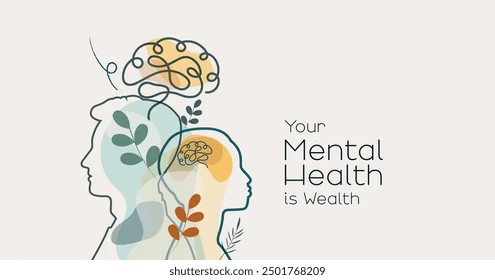

In [16]:
# Base64 is a way of encoding binary data (like images, files, or videos) into a text format using only ASCII characters (letters, numbers, and a few symbols)
# Base64 converts an image (or any file) into text.

import base64
from io import BytesIO
from PIL import Image

# model except image in base64 format
def extract_text_from_image(pil_image,format="png"):
    buffered = BytesIO()
    pil_image.save(buffered,format=format)
    img_base64 = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/{format.lower()};base64,{img_base64}"  # data : It tells the browser or application that the content which follows is not a normal URL, but actual data

pil = Image.open("image/1.webp")
image = extract_text_from_image(pil)

pil

In [ ]:

def create_vision_message(pil_image,query):
    message = HumanMessage(content=[{
        "type":"text",
        "text":query},
        {
            "type":"image_url",
            "image_url":{"url":pil_image}
        }
        ])
    return message
    
message = create_vision_message(image,"explain this image")

vision_result = vision_model.invoke([message]).content

display(Markdown(vision_result))

The image presents a thought-provoking visual representation of mental health, featuring two human heads with a brain and plants integrated into the design. The image conveys a message about the importance of mental well-being.

*   **Two Human Heads**
    *   The two human heads are depicted in profile, facing to the right.
    *   They are outlined in black and have a minimalist style.
    *   The heads are overlapping, with one head positioned behind the other.
*   **Brain**
    *   A brain is shown above the heads, also outlined in black.
    *   The brain features a yellow and orange color scheme with darker yellow lines and circles.
    *   It appears to be emerging from the top of the heads or floating above them.
*   **Plants**
    *   Green and orange leaves and stems are integrated into the design of the heads and brain.
    *   The plants add a natural and organic feel to the image.
    *   They may symbolize growth, harmony, and balance related to mental health.
*   **Text**
    *   The text "Your Mental Health is Wealth" is displayed on the right side of the image.
    *   The font is simple and easy to read.
    *   The message emphasizes the value and importance of maintaining good mental health.
*   **Background**
    *   The background of the image is a light beige color.
    *   It provides a clean and neutral backdrop for the illustration and text.

In summary, the image effectively conveys the significance of prioritizing mental health through its visually appealing and symbolic design. The use of human heads, a brain, and plants creates a powerful representation of the interconnectedness of mental well-being and overall wealth.

In [30]:
def create_vision_message(pil_image,query):
    message = HumanMessage(content=[{
        "type":"text",
        "text":query},
        {
            "type":"image_url",
            "image_url":{"url":pil_image}}])
    return message
message = create_vision_message(image,"explain this image")



def context_format(context):
    return "\n\n".join(getattr(doc,"page_content") for doc in context)

parallel_chain = RunnableParallel({
      "context": final_retriever | RunnableLambda(context_format),
      "question":RunnablePassthrough(),
      "image":RunnablePassthrough()
  })

vision_chain = parallel_chain | RunnableLambda(message) | model | parser 

vision_chain.invoke()

TypeError: Expected a callable type for `func`.Instead got an unsupported type: <class 'langchain_core.messages.human.HumanMessage'>

## Record Audio

In [24]:
import speech_recognition as sr
from pydub import AudioSegment
from io import BytesIO
import logging

In [30]:
logging.basicConfig(level=logging.INFO,format="%(asctime)s - %(levelname)s - %(message)s")

# %(asctime)s: Timestamp of the log entry
# %(levelname)s: Log level (INFO, WARNING, ERROR, etc.)
# %(message)s: The actual log message

In [39]:

def record_audio(save_path):
    recognizer = sr.Recognizer()
    try:
        with sr.Microphone() as source:
            logging.info("adjusting ambient noise....")
            recognizer.adjust_for_ambient_noise(source,duration=1)
            logging.info("Start speaking now....")

            audio = recognizer.listen(source=source,timeout=15)
            logging.info("Recording completed")

            wav_data = audio.get_wav_data()
            audio_segment = AudioSegment.from_file(BytesIO(wav_data),format="wav")

            audio_segment.export(save_path,format="mp3",bitrate="128k")
            logging.info(f"Audio File saved to {save_path}")
    except Exception as e:
        logging.error(f"Error : {e}")


os.makedirs("Audio/Input_audio",exist_ok=True)
save_path =  "Audio/Input_audio/user_input.mp3"
record_audio(save_path=save_path)

2025-05-26 19:38:34,537 - INFO - adjusting ambient noise....
2025-05-26 19:38:35,537 - INFO - Start speaking now....
2025-05-26 19:38:41,210 - INFO - Recording completed
2025-05-26 19:38:43,003 - INFO - Audio File saved to Audio/Input_audio/user_input.mp3


## Voice to Text

In [45]:
from groq import Groq
model_stt = "whisper-large-v3-turbo"

In [47]:
client = Groq()
model_stt = "whisper-large-v3-turbo"
audio_file = open(save_path,"rb")

transcription = client.audio.transcriptions.create(
    model = model_stt,
    file = audio_file,
    language = "en"
)

print(transcription.text)


2025-05-26 19:47:50,174 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"


 My name is Hasib.
